In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import sklearn.model_selection as model_selection
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

import sklearn, h5py
from sklearn.externals import joblib

import neuravi

import pandas as pd

/Users/charles/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charles/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# model with TensorFlow and A-G

The past example with scikit-learn directly relates the melt composition and temperature to it's viscosity.

We saw that the problem with this approach is that it underuses our knowledge of how viscosity and temperature vary. This creates too much noise when predicting viscosity over T for one composition.

A way to solve that is to use the neiural net to map the chemical dependence of the parameters that enter into the equation(s) that link viscosity to temperature. As we can use any equation, best if we can actually use the Adam and Gibbs one as it bring thermodynamic information on the melt.

If neural nets work, it should return an internally consistent model that should predict well the entropy and heat capacity of the melt.

Good thing is we know those values for some melts, such that we can trully quantify the success of the neural net.

$a^b$

The viscosity equation is:


$$log(\eta) = A_{e} + \frac{B_{e}}{T \times (S^{conf}(T_{g}) + \int_{T_{g}}^{T} \frac{\Delta C_p}{T} dT)}$$ 

where 

$$ \int_{T_{g}}^{T} \frac{\Delta C_p}{T} dT = ap \times (log(T) - log(T_{g})) + b \times(T-T_{g}) $$


$A_{e}$ is a constant proportional to the viscosity at infinite temperature. It barely depends on melt composition.

$B_{e}$ is a constant proportional to energy barriers opposed to viscous flow. It strongly depends on melt composition.

S^{conf}(T_{g}) is the configurational entropy of the melt at the glass transition temperature $T_g$ (temperature at which you consider that the melt becomes a glass.

$ap$ and $b$ are parameters that depend on melt composition. We have data and models for those; they nearly linearly depend on melt composition. (this can be discussed for b)

## Approach with neural net

The idea is to link the melt composition (14 variables) to the parameters $A_{e}$, $B_{e}$, $S^{conf}(T_{g})$, $ap$ and $b$ with a neural network.

We can calculate $T_{g}$ as 

$$ T_{g} = \frac{B_{e}}{((12.0-A_{e}) \times S^{conf}(T_{g}))} $$

with the empirical definition that $T_{g}$ occurs when the viscosity reaches around 12 log Pa $\cdot$ s.

This helps removing one parameter and should help to have a self-consistent model.

At this stage, we could use existing models for $ap$ and $b$, but there we assume that those models, which are 30 years old, are good-enough.

Another approach, which I adopt in the following, is to let the neural net determines $ap$ and $b$, such that we can compore those in the future with existing models.

If the neural net is good, we should find consistent results.

## Let's start

First I define the arrays that store the chemical composition and temperature.

viscosity (y values) are already saved in y_train/y_valid/y_test.

# Loading dataset

Dataset has been prepared before`

In [2]:
f = h5py.File("./data/DataSet.hdf5", 'r')
# List all groups
X_columns = f['X_columns'].value

X_tv = f["X_tv"].value
X_tv_sc = f["X_tv_sc"].value
y_tv = f["y_tv"].value

X_test = f["X_test"].value
X_test_sc = f["X_test_sc"].value
y_test = f["y_test"].value

X_scaler_mean = f["X_scaler_mean"].value
X_scaler_var = f["X_scaler_var"].value

f.close()

print("loaded")
print("\nFeatures in X_ arrays are")
print(X_columns)
print("\nShape of X train and valid is")
print(X_tv.shape)

# Put unscaled values for ap, b, T, Be and Sc in X_tv_sc and X_test_sc
X_tv_sc[:,4:] = X_tv[:,4:]
X_test_sc[:,4:] = X_test[:,4:]

loaded

Features in X_ arrays are
[b'sio2' b'al2o3' b'na2o' b'k2o' b'ap' b'b' b'T' b'Be' b'Sc' b'tg']

Shape of X train and valid is
(689, 10)


In [3]:
X_train_sc, X_valid_sc, y_train, y_valid =  model_selection.train_test_split(X_tv_sc,y_tv,test_size=0.33,shuffle=True)

# we have the chemical composition as X train/valid/test, but also the temperature

chimie_train = X_train_sc[:,0:4] # 14 for all dataset, 4 for KNAS
cp_train = X_train_sc[:,(4,5)]
temperature_train = X_train_sc[:,6].reshape(-1,1)

Be_train = X_train_sc[:,7].reshape(-1,1)
Sc_train = X_train_sc[:,8].reshape(-1,1)

chimie_valid = X_valid_sc[:,0:4]
cp_valid = X_valid_sc[:,(4,5)]
temperature_valid = X_valid_sc[:,6].reshape(-1,1)

Be_valid = X_valid_sc[:,7].reshape(-1,1)
Sc_valid = X_valid_sc[:,8].reshape(-1,1)

chimie_test = X_test_sc[:,0:4]
cp_test = X_test_sc[:,(4,5)]
temperature_test = X_test_sc[:,6].reshape(-1,1)

We then create an object to create a network with 1 to 5 layers (ReLu activation units + dropout),

Following the reading of Kaufl, we will initiate the bias of the output neural net layer to values of parameters that are not far from reality.

Then results of output layer are used to calculate the parameters of the A-G equation (see above), which, in turn, gives the viscosity.

We use a L2 loss to determine distance from targets.

Optimizer is RMSprop, it seems the most stable from my test.

The code for the object is in the file neuravi.py

In [4]:
class Model_AG_withCp2(object):
    """
    derived from  https://github.com/adventuresinML/adventures-in-ml-code/blob/master/weight_init_tensorflow.py
    """
    def __init__(self, input_size, 
                num_layers=3,
                hidden_size=100,
                stdev = 0.01,
                init_be = np.array([np.log(40000.)]),
                init_sc = np.array([np.log(5.1)]),
                learning_rate = 1e-4):
        
        self._input_size = input_size
        self._num_layers = num_layers # num layers does not include the input layer
        self._hidden_size = hidden_size # all layers have the same number of hidden units
        self._out_size = 1 # fixed regarding the problem shape: 3 parameters to determine
        self._init_bias_be = init_be
        self._init_bias_sc = init_sc
        self._stdev = stdev
        self._learning_rate = learning_rate
        self._model_def()
        
    def _model_def(self):
        # create placeholder variables
        self.input_c = tf.placeholder(dtype=tf.float32, shape=[None,self._input_size], name="chimie")
        self.input_cp_a = tf.placeholder(dtype=tf.float32, shape=[None,1], name="cp_a")
        self.input_cp_b = tf.placeholder(dtype=tf.float32, shape=[None,1], name="cp_b")
        self.input_T = tf.placeholder(dtype=tf.float32, shape=[None,1], name="T")
        self.input_y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="viscosity")
        self.prob = tf.placeholder_with_default(1.0, shape=())

       
            
        self.Wh1 = tf.Variable(tf.random_normal([self._input_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
        self.bh1 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
        self.hidden_layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.input_c, self.Wh1) + self.bh1),
                                                keep_prob=self.prob,
                                                name="layerA")
            
       
            
        self.Wh2 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
        self.bh2 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))

        self.hidden_layer_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_1, self.Wh2) + self.bh2),
                                                keep_prob=self.prob,
                                                name="layerB")
        
        
        self.W1 = tf.Variable(tf.random_normal([self._hidden_size,self._out_size], mean=0.,stddev=self._stdev, dtype=tf.float32))
        self.b1 = tf.Variable(tf.random_normal([1,self._out_size], mean=self._init_bias_be, stddev=self._init_bias_be*self._stdev, dtype=tf.float32))

        self.W2 = tf.Variable(tf.random_normal([self._hidden_size,self._out_size], mean=0.,stddev=self._stdev, dtype=tf.float32))
        self.b2 = tf.Variable(tf.random_normal([1,self._out_size], mean=self._init_bias_sc,stddev=self._init_bias_sc*self._stdev, dtype=tf.float32))

        self.be_ = tf.add(tf.matmul(self.hidden_layer_1,self.W1),self.b1,name="Be_ph")
        self.sctg_ = tf.add(tf.matmul(self.hidden_layer_2,self.W2),self.b2,name="ScTg_ph")
        
        #
        # Adam and Gibbs with network outputs
        #
        self.ae = tf.get_variable("Ae", initializer=-2.11)

        #self.ae = tf.Variable(tf.tensor([-2.11]),name="Ae")
        
        # cannot be negative
        self.be = tf.exp(self.be_,name="Be")
        self.sctg = tf.exp(self.sctg_,name="entropy_Tg")
        
        self.tg = tf.divide(self.be,np.multiply((12.0-self.ae),self.sctg),name="Tg")
        
        self.dCp = tf.add(tf.multiply(self.input_cp_a,(tf.log(self.input_T)-tf.log(self.tg))),
                          tf.multiply(self.input_cp_b,(self.input_T-self.tg)),name="dCp")

        self.entropy = tf.add(self.sctg,self.dCp,name="entropy_T")

        self.denom_n =tf.multiply(self.input_T,self.entropy,name="denominator_AG")
        
        self.visco_pred = tf.add(self.ae,np.divide(self.be,self.denom_n),name="visco_pred")
        
        #
        #self.loss = tf.sum(tf.square(tf.subtract(self.visco_pred,self.input_y)),name="loss_fct")
        self.loss_n = tf.nn.l2_loss(self.visco_pred-self.input_y,name="loss_n")
        self.loss_be = tf.nn.l2_loss(self.be-self.input_y,name="loss_be")
        self.loss_sc = tf.nn.l2_loss(self.sctg-self.input_y,name="loss_sc")
                                                                            
        # add the loss to the summary
        tf.summary.scalar('loss_n', self.loss_n)
        tf.summary.scalar('loss_Be', self.loss_be)
        tf.summary.scalar('loss_Sc', self.loss_sc)
        self.optimizer_n = tf.train.AdamOptimizer(self._learning_rate).minimize(self.loss_n)
        self.optimizer_be = tf.train.AdamOptimizer(self._learning_rate).minimize(self.loss_be)
        self.optimizer_sc = tf.train.AdamOptimizer(self._learning_rate).minimize(self.loss_sc)
        
        self.merged = tf.summary.merge_all()
        self.init_op = tf.global_variables_initializer()  

class Model_AG_withCp(object):
    """
    derived from  https://github.com/adventuresinML/adventures-in-ml-code/blob/master/weight_init_tensorflow.py
    """
    def __init__(self, input_size, 
                num_layers=3,
                hidden_size=100,
                stdev = 0.01,
                init_bias = np.array([np.log(40000.),np.log(5.1)]),
                learning_rate = 1e-4):
        
        self._input_size = input_size
        self._num_layers = num_layers # num layers does not include the input layer
        self._hidden_size = hidden_size # all layers have the same number of hidden units
        self._out_size = 2 # fixed regarding the problem shape: 3 parameters to determine
        self._init_bias = init_bias
        self._stdev = stdev
        self._learning_rate = learning_rate
        self._model_def()
        
    def _model_def(self):
        # create placeholder variables
        self.input_c = tf.placeholder(dtype=tf.float32, shape=[None,self._input_size], name="chimie")
        self.input_cp_a = tf.placeholder(dtype=tf.float32, shape=[None,1], name="cp_a")
        self.input_cp_b = tf.placeholder(dtype=tf.float32, shape=[None,1], name="cp_b")
        self.input_T = tf.placeholder(dtype=tf.float32, shape=[None,1], name="T")
        self.input_y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="viscosity")
        self.prob = tf.placeholder_with_default(1.0, shape=())

        if self._num_layers >= 1:
            
            self.Wh1 = tf.Variable(tf.random_normal([self._input_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh1 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.input_c, self.Wh1) + self.bh1),
                                                keep_prob=self.prob,
                                                name="layer1")
            
        if self._num_layers >= 2:
            
            self.Wh2 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh2 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))

            self.hidden_layer_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_1, self.Wh2) + self.bh2),
                                                keep_prob=self.prob,
                                                name="layer2")
        
        if self._num_layers >= 3:
        
            self.Wh3 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh3 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_3 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_2, self.Wh3) + self.bh3),
                                                keep_prob=self.prob,
                                                name="layer3")    
        if self._num_layers >= 4:
        
            self.Wh4 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh4 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_4 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_3, self.Wh4) + self.bh4),
                                                keep_prob=self.prob,
                                                name="layer4")
            
        if self._num_layers == 5:
        
            self.Wh5 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            self.bh5 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=self._stdev, dtype=tf.float32))
            
            self.hidden_layer_5 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_4, self.Wh5) + self.bh5),
                                                keep_prob=self.prob,
                                                name="layer5")

        self.Wo = tf.Variable(tf.random_normal([self._hidden_size,self._out_size], mean=0.,stddev=self._stdev, dtype=tf.float32))
        self.bo = tf.Variable(tf.random_normal([1,self._out_size], mean=self._init_bias, stddev=self._init_bias*self._stdev, dtype=tf.float32))

        if self._num_layers == 1:
            self.output = tf.add(tf.matmul(self.hidden_layer_1,self.Wo),self.bo,name="out_neurons")
        elif self._num_layers == 2:
            self.output = tf.add(tf.matmul(self.hidden_layer_2,self.Wo),self.bo,name="out_neurons")
        elif self._num_layers == 3:
            self.output = tf.add(tf.matmul(self.hidden_layer_3,self.Wo),self.bo,name="out_neurons")
        elif self._num_layers == 4:
            self.output = tf.add(tf.matmul(self.hidden_layer_4,self.Wo),self.bo,name="out_neurons")
        elif self._num_layers == 5:
            self.output = tf.add(tf.matmul(self.hidden_layer_5,self.Wo),self.bo,name="out_neurons")
        else:
            print("Error: choose between 1 to 5 layers")
        
        #
        # Adam and Gibbs with network outputs
        #
        #self.ae = tf.placeholder(dtype=tf.float32, shape=[None,1], name="Ae_ph")
        self.be_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="Be_ph")
        self.sctg_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="ScTg_ph")
        
        self.ae = tf.Variable(tf.tensor([-2.11]),name="Ae")
        
        self.be_, self.sctg_ = tf.split(self.output,2,axis=1)

        # cannot be negative
        self.be = tf.exp(self.be_,name="Be")
        self.sctg = tf.exp(self.sctg_,name="entropy_Tg")
        
        self.tg = tf.divide(self.be,np.multiply((12.0-self.ae),self.sctg),name="Tg")
        
        self.dCp = tf.add(tf.multiply(self.input_cp_a,(tf.log(self.input_T)-tf.log(self.tg))),
                          tf.multiply(self.input_cp_b,(self.input_T-self.tg)),name="dCp")

        self.entropy = tf.add(self.sctg,self.dCp,name="entropy_T")

        self.denom_n =tf.multiply(self.input_T,self.entropy,name="denominator_AG")
        
        self.visco_pred = tf.add(self.ae,np.divide(self.be,self.denom_n),name="visco_pred")
        
        #
        #self.loss = tf.sum(tf.square(tf.subtract(self.visco_pred,self.input_y)),name="loss_fct")
        self.loss_n = tf.nn.l2_loss(self.visco_pred-self.input_y,name="loss_n")
        self.loss_be = tf.nn.l2_loss(self.be-self.input_y,name="loss_be")
        self.loss_sc = tf.nn.l2_loss(self.sctg-self.input_y,name="loss_sc")
                                                                            
        # add the loss to the summary
        tf.summary.scalar('loss_n', self.loss_n)
        tf.summary.scalar('loss_Be', self.loss_be)
        tf.summary.scalar('loss_Sc', self.loss_sc)
        self.optimizer_n = tf.train.RMSPropOptimizer(self._learning_rate).minimize(self.loss_n)
        self.optimizer_be = tf.train.RMSPropOptimizer(self._learning_rate).minimize(self.loss_be)
        self.optimizer_sc = tf.train.RMSPropOptimizer(self._learning_rate).minimize(self.loss_sc)
        
        self.merged = tf.summary.merge_all()
        self.init_op = tf.global_variables_initializer()  

In [5]:
Be_train.shape

(461, 1)

In [6]:
NIN = chimie_train.shape[1]
NHIDDEN = 200
NLAYER = 1
STDEV = 0.001

mod = Model_AG_withCp2(NIN, num_layers=NLAYER, hidden_size=NHIDDEN)

We start a TF Interactive Session to initiate our model, and look at the initial predictions.

The idea is to avoid starting the training with an initial model very far from reality...

So we run this cell again and again until we see a relatively close correspondance.

Initial predictions should be in a -5 - 20 range... If not, too much iterations are required for proper convergence...

We just avoid values at 10^20....

OK, no interactive session running


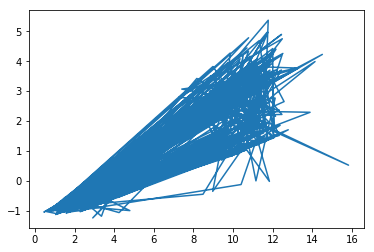

In [7]:
try:
    sess.close()
except:
    print("OK, no interactive session running")

sess = tf.InteractiveSession()
sess.run(mod.init_op)



pred_ini= sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_train,
                                             mod.input_cp_a: cp_train[:,0].reshape(-1,1),
                                             mod.input_cp_b: cp_train[:,1].reshape(-1,1),
                                             mod.input_T: temperature_train, 
                                             mod.input_y: y_train.reshape(-1,1)})
plt.figure()
plt.plot(y_train, pred_ini)

We then train the network for 50,000 iterations. We use the full batch. Should not be a problem as our dataset is relatively small.

Convergence is slow.

I do not perform early stopping (lines are commented) as it does not bring anything to the training. It stops the training too early.

Furthermore, good validation and testing errors are in general obtained because we use dropout, which favour generalization.

In [8]:
chimie_valid.shape

(228, 4)

In [9]:
NEPOCH = 5000
loss_train = np.zeros(NEPOCH) # store the training progress here.
loss_valid = np.zeros(NEPOCH) # store the training progress here.

early_stop = 1000 # not used below
count_es = 0

for i in range(NEPOCH):
    dct_train = {mod.prob: 1.0, mod.input_c: chimie_train, 
                 mod.input_cp_a: cp_train[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_train[:,1].reshape(-1,1),
                 mod.input_T: temperature_train, mod.input_y: Sc_train.reshape(-1,1)}
    
    dct_valid = {mod.input_c: chimie_valid, 
                 mod.input_cp_a: cp_valid[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_valid[:,1].reshape(-1,1),
                 mod.input_T: temperature_valid, mod.input_y: Sc_valid.reshape(-1,1)}
    
    sess.run(mod.optimizer_sc,feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss_sc, feed_dict=dct_train)
    loss_valid[i] = sess.run(mod.loss_sc, feed_dict=dct_valid)
    
    if (i % 500 == 0):
            print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
    # implement early stopping
    if loss_valid[i]>loss_valid[i-1]: # this is increasing if the new iteration valid RMSE is higher than the old
        count_es += 1
    else: # if it starts decreasing again, we put things back to 0
        count_es = 0
        
    #if count_es > early_stop:
    #    break
        

Batch train and valid loss at step 0: 9025.712890625, 4349.95703125
Batch train and valid loss at step 500: 346.2896423339844, 197.78985595703125
Batch train and valid loss at step 1000: 65.7226333618164, 38.558712005615234
Batch train and valid loss at step 1500: 15.844298362731934, 7.824985027313232
Batch train and valid loss at step 2000: 4.313688278198242, 1.911097764968872
Batch train and valid loss at step 2500: 1.2893203496932983, 0.6229535937309265
Batch train and valid loss at step 3000: 0.623490035533905, 0.3274106979370117
Batch train and valid loss at step 3500: 0.4140947759151459, 0.22194482386112213
Batch train and valid loss at step 4000: 0.25310736894607544, 0.13506802916526794
Batch train and valid loss at step 4500: 0.14367644488811493, 0.076207235455513


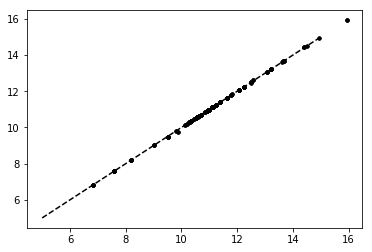

In [10]:
plt.plot(Sc_train,sess.run(mod.sctg, feed_dict=dct_train),"k.")
plt.plot([5,15],[5,15],"k--")

In [11]:
NEPOCH = 5000
loss_train = np.zeros(NEPOCH) # store the training progress here.
loss_valid = np.zeros(NEPOCH) # store the training progress here.

early_stop = 1000 # not used below
count_es = 0

for i in range(NEPOCH):
    dct_train = {mod.prob: 1.0, mod.input_c: chimie_train, 
                 mod.input_cp_a: cp_train[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_train[:,1].reshape(-1,1),
                 mod.input_T: temperature_train, mod.input_y: Be_train.reshape(-1,1)}
    
    dct_valid = {mod.input_c: chimie_valid, 
                 mod.input_cp_a: cp_valid[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_valid[:,1].reshape(-1,1),
                 mod.input_T: temperature_valid, mod.input_y: Be_valid.reshape(-1,1)}
    
    sess.run(mod.optimizer_be,feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss_be, feed_dict=dct_train)
    loss_valid[i] = sess.run(mod.loss_be, feed_dict=dct_valid)
    
    if (i % 500 == 0):
            print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
    # implement early stopping
    if loss_valid[i]>loss_valid[i-1]: # this is increasing if the new iteration valid RMSE is higher than the old
        count_es += 1
    else: # if it starts decreasing again, we put things back to 0
        count_es = 0
        
    #if count_es > early_stop:
    #    break
        

Batch train and valid loss at step 0: 2621346152448.0, 1310719475712.0
Batch train and valid loss at step 500: 110402445312.0, 61529759744.0
Batch train and valid loss at step 1000: 37141377024.0, 19239247872.0
Batch train and valid loss at step 1500: 21396373504.0, 10829639680.0
Batch train and valid loss at step 2000: 15008172032.0, 7250360832.0
Batch train and valid loss at step 2500: 11631722496.0, 5418197504.0
Batch train and valid loss at step 3000: 8968518656.0, 4130774784.0
Batch train and valid loss at step 3500: 7424778240.0, 3372741632.0
Batch train and valid loss at step 4000: 6145540096.0, 2824528896.0
Batch train and valid loss at step 4500: 4802003968.0, 2311459072.0


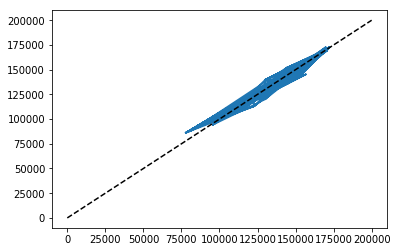

In [12]:
plt.plot(Be_train,sess.run(mod.be, feed_dict=dct_train))
plt.plot([0,200000],[0,200000],"k--")

In [13]:
NEPOCH = 13000
loss_train = np.zeros(NEPOCH) # store the training progress here.
loss_valid = np.zeros(NEPOCH) # store the training progress here.

early_stop = 1000 # not used below
count_es = 0

for i in range(NEPOCH):
    dct_train = {mod.prob: 1.0, mod.input_c: chimie_train, 
                 mod.input_cp_a: cp_train[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_train[:,1].reshape(-1,1),
                 mod.input_T: temperature_train, mod.input_y: y_train.reshape(-1,1)}
    
    dct_valid = {mod.input_c: chimie_valid, 
                 mod.input_cp_a: cp_valid[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_valid[:,1].reshape(-1,1),
                 mod.input_T: temperature_valid, mod.input_y: y_valid.reshape(-1,1)}
    
    sess.run(mod.optimizer_n,feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss_n, feed_dict=dct_train)
    loss_valid[i] = sess.run(mod.loss_n, feed_dict=dct_valid)
    
    if (i % 500 == 0):
            print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
    # implement early stopping
    if loss_valid[i]>loss_valid[i-1]: # this is increasing if the new iteration valid RMSE is higher than the old
        count_es += 1
    else: # if it starts decreasing again, we put things back to 0
        count_es = 0
        
    #if count_es > early_stop:
    #    break
        

Batch train and valid loss at step 0: 11717.0166015625, 6202.931640625
Batch train and valid loss at step 500: 86.6213607788086, 48.38622283935547
Batch train and valid loss at step 1000: 35.634281158447266, 17.448488235473633
Batch train and valid loss at step 1500: 20.481569290161133, 9.825060844421387
Batch train and valid loss at step 2000: 13.050457954406738, 6.965527057647705
Batch train and valid loss at step 2500: 10.107928276062012, 5.921404838562012
Batch train and valid loss at step 3000: 8.813852310180664, 5.321435928344727
Batch train and valid loss at step 3500: 8.068451881408691, 4.898841857910156
Batch train and valid loss at step 4000: 7.674988746643066, 4.683919906616211
Batch train and valid loss at step 4500: 7.403451442718506, 4.5749077796936035
Batch train and valid loss at step 5000: 7.184217929840088, 4.532050132751465
Batch train and valid loss at step 5500: 7.028476238250732, 4.434312343597412
Batch train and valid loss at step 6000: 7.0895562171936035, 4.4203

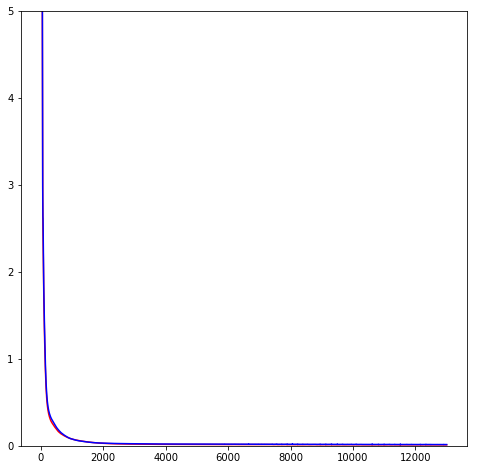

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(0, NEPOCH,1), loss_train/X_train_sc.shape[0], 'r-')
plt.plot(np.arange(0, NEPOCH,1), loss_valid/X_valid_sc.shape[0], 'b-')
plt.ylim(0,5)
plt.show()
plt.savefig("epochs_ag.pdf")

Here this is supposed to save the model, which then can be re-used by tensorflow server...

In [18]:
name_out = "KNAS_AG2_layer_"+str(NLAYER)+"units_"+str(NHIDDEN)+"it_"+str(NEPOCH)

tf.saved_model.simple_save(sess,
            "./model/"+name_out,
            inputs={"chimie": mod.input_c, "T": mod.input_T},
            outputs={"visco_pred": mod.visco_pred})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/KNAS_AG2_layer_1units_200it_13000/saved_model.pb


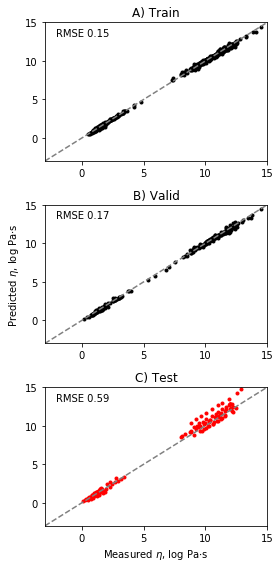

In [17]:
train_pred_out = sess.run(mod.visco_pred,feed_dict=dct_train)
valid_pred_out = sess.run(mod.visco_pred,feed_dict=dct_valid)
test_pred_out = sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_test, 
                 mod.input_cp_a: cp_test[:,0].reshape(-1,1),
                 mod.input_cp_b: cp_test[:,1].reshape(-1,1),
                 mod.input_T: temperature_test, mod.input_y: y_test.reshape(-1,1)})

plt.figure(figsize=(4,8))
plt.subplot(3,1,1)
plt.title("A) Train")
plt.plot(y_train, train_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_train, train_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.subplot(3,1,2)
plt.title("B) Valid")
plt.plot(y_valid, valid_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_valid, valid_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.ylabel("Predicted $\eta$, log Pa$\cdot$s")

plt.subplot(3,1,3)
plt.title("C) Test")
plt.plot(y_test, test_pred_out,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(y_test, test_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.xlabel("Measured $\eta$, log Pa$\cdot$s")

plt.tight_layout()